# Create the graph based on two separate masks

In [1]:
# set the contraction / link addtion threshold

thres = 0.05

### Contracted Graph

In [2]:
import pandas as pd
from scipy.sparse.csgraph import connected_components
import preprocessing.preprocessing as pp
import graph_matching.graph_matching as gm
from visualization import graph_to_mesh, mesh_viewer
import numpy as np

nodesFileNerve =  "~/Documents/Intestine/nerve-mask/nodes_nerve_bs2_fh.csv"
edgesFileNerve = "~/Documents/Intestine/nerve-mask/edges_nerve_bs2_fh.csv"

nodesFileLymph =  "~/Documents/Intestine/lymph-mask/nodes_lymph_bs2_fh.csv"
edgesFileLymph = "~/Documents/Intestine/lymph-mask/edges_lymph_bs2_fh.csv"

nodes_n = pd.read_csv(nodesFileNerve, sep = ";", index_col= "id")
edges_n = pd.read_csv(edgesFileNerve, sep = ";", index_col= "id")
nodes_l = pd.read_csv(nodesFileLymph, sep = ";", index_col= "id")
edges_l = pd.read_csv(edgesFileLymph, sep = ";", index_col= "id")


# scaling with the factors provided by luciano
nodes_l = pp.scalePosition(nodes_l, (1.65,1.65,6))
nodes_n = pp.scalePosition(nodes_n, (1.65,1.65,6))


# giving nodes from different files unique names
edges_n, nodes_n = pp.relable_edges_nodes(edges_n, nodes_n, "n")
edges_l, nodes_l = pp.relable_edges_nodes(edges_l, nodes_l, "l")


adjMcsr = pp.distance_based_adjacency(nodes_n, nodes_l, th = thres)
num, labels = connected_components(csgraph=adjMcsr, directed = False)
con_comp = pp.connected_components_dict(labels)
rel_comp = pp.relevant_connected_components(con_comp, nodes_n.shape[0], ("n","l"))


contractions = np.sum([len(val) for val in rel_comp.values()])
new_nodes = len(list(rel_comp.keys()))
print("The total number of contracted nodes: " + str(contractions))
print("The total number of resulting nodes: " + str(new_nodes))


reverse_dict= {}
for k, v in rel_comp.items():
    for val in v:
        reverse_dict[val] = k



merged_nodes = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])
new_nodes = pd.DataFrame(columns=merged_nodes.columns )


# replace the contracted node with new nodes
# the position of the new node is an average of all the previous nodes
for k, valList in rel_comp.items():
    new_nodes.loc[k] = merged_nodes.loc[valList].mean()
    merged_nodes.drop(valList, inplace = True)

# concat the all nodes and the new nodes
merged_nodes = pd.concat([merged_nodes, new_nodes])

# createa a combined edge file
merged_edges = pd.concat([edges_l, edges_n], ignore_index = True)

# change the names of the edges to the new names
for idxE, edge in merged_edges.iterrows():
    if edge["node1id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node1id"] = reverse_dict[edge["node1id"]]
    if edge["node2id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node2id"] = reverse_dict[edge["node2id"]]



# make a setting for self loops and isolates 
sloop = 0
isol = 0

# create a new graph based on the old information

G_contract = pp.createGraph(merged_nodes, merged_edges)
G_contract_einf_sep = pp.convertToEinfach(G_contract, self_loops = sloop, isolates = isol)

The total number of contracted nodes: 796
The total number of resulting nodes: 287


### Link addition graph

In [13]:
dist_mat_sparse = pp.network_sparse_distance_matrix(nodes_n, nodes_l, th = thres)
merged_edges_link = pd.concat([edges_l, edges_n], ignore_index = True)

new_links = pd.DataFrame(data = np.zeros((dist_mat_sparse.nnz, len(merged_edges_link.columns))), columns=merged_edges_link.columns)

average_edge = merged_edges_link.median()
ld_ratio = average_edge[0] / average_edge[1]

i = -1
for key, val in dist_mat_sparse.items():
    i = i+ 1
    new_links.loc[i][2:] = average_edge
    new_links.loc[i]["distance"] = float(val)
    new_links.loc[i]["length"] = float(val*ld_ratio)
    new_links.loc[i]["node1_degree"] = nodes_n.loc[str(key[0]) + "n"]["degree"] +1 
    new_links.loc[i]["node2_degree"] = nodes_l.loc[str(key[1]) + "l"]["degree"] +1
    new_links.loc[i]["node1id"] = str(key[0]) + "n"
    new_links.loc[i]["node2id"] = 1


new_links["node1id"] = [str(elem[0]) + "n" for elem in dist_mat_sparse.keys()]
new_links["node2id"] = [str(elem[1]) + "l" for elem in dist_mat_sparse.keys()]

merged_edges_link_f = pd.concat([merged_edges_link, new_links], ignore_index = True)
merged_nodes_link_f = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])


# create a new graph based on the old information
G_link = pp.createGraph(merged_nodes_link_f, merged_edges_link_f)
G_link_einf_sep = pp.convertToEinfach(G_link, self_loops = False, isolates = False)

print(G_link.order())
print(G_link.size())

4013
5653


# Create the graph based on a combined mask 

In [14]:
nodesFileComb =  "~/Documents/Intestine/combined-mask/nodes_bs2_fh.csv"
edgesFileComb = "~/Documents/Intestine/combined-mask/edges_bs2_fh.csv"

nodes_c = pd.read_csv(nodesFileComb, sep = ";", index_col= "id")
edges_c = pd.read_csv(edgesFileComb, sep = ";", index_col= "id")

print(nodes_c.shape[0])
print(edges_c.shape[0])

# scaling with the factors provided by luciano
nodes_c = pp.scalePosition(nodes_c, (1.65,1.65,6))


G_contract_comb = pp.createGraph(nodes_c, edges_c)
G_contract_einf_comb = pp.convertToEinfach(G_contract_comb, self_loops = sloop, isolates = isol)

3715
5135


# Compare properties of both graphs

In [15]:
pp.graphSummary(G_contract_einf_sep)
pp.graphSummary(G_contract_einf_comb)
pp.graphSummary(G_link_einf_sep)

'''The combined graph seems to be way more connected than the graph from separate extraction. More edges for less nodes. Less than half the connected components. '''

***************
Number of Nodes: 3504
Number of Edges: 4806
Number of Connected Components: 33
Number of Self Loops: 0
Number of Isolated Nodes: 0
Average Node Degree: 2.743150684931507
***************
***************
Number of Nodes: 3715
Number of Edges: 5100
Number of Connected Components: 17
Number of Self Loops: 0
Number of Isolated Nodes: 0
Average Node Degree: 2.7456258411843875
***************
***************
Number of Nodes: 4013
Number of Edges: 5593
Number of Connected Components: 33
Number of Self Loops: 0
Number of Isolated Nodes: 0
Average Node Degree: 2.7874408173436334
***************


'The combined graph seems to be way more connected than the graph from separate extraction. More edges for less nodes. Less than half the connected components. '

In [6]:
import matplotlib.pyplot as plt

# get the neare
res = gm.nearestNeighborNode(G_contract_einf_sep, G_contract_einf_comb)


print("Total Distance: " + str(np.sum(res[0])))
print("Average Distance: " + str(np.mean(res[0])))
print("Median Distance: " + str(np.median(res[0])))


G_contract_einf_comb_relab = gm.nearestNeighborLabeling(G_contract_einf_sep, G_contract_einf_comb)


sep_class_labels = [val[-1] for val in G_contract_einf_sep.nodes()]
comb_class_labels = [val[-1] for val in G_contract_einf_comb_relab.nodes()]

print(np.unique(sep_class_labels, return_counts = True))
print(np.unique(comb_class_labels, return_counts = True))

# what is the avg deviation of the node degree to its match node degree?

sep_node_list = np.array(list(G_contract_einf_sep.nodes()))

deg_dev = []
for i, m_node_idx in enumerate(res[1]):
    deg1 = G_contract_einf_comb.degree[i]
    m_node = sep_node_list[m_node_idx]
    deg2 = G_contract_einf_sep.degree[m_node]
    deg_dev.append(deg1-deg2)


deg_dev_abs = np.abs(deg_dev)
print("Mean difference in the degree compared to match nodes: " + str(np.mean(deg_dev_abs)))
print("Median difference in the degree compared to match nodes: " + str(np.median(deg_dev_abs)))

Total Distance: 87.77678892387465
Average Distance: 0.023627668620154682
Median Distance: 0.017285923396220433
(array(['c', 'l', 'n'], dtype='<U1'), array([ 287, 1773, 1444]))
(array(['c', 'l', 'n'], dtype='<U1'), array([ 489, 1828, 1398]))
Mean difference in the degree compared to match nodes: 0.54185733512786
Median difference in the degree compared to match nodes: 0.0


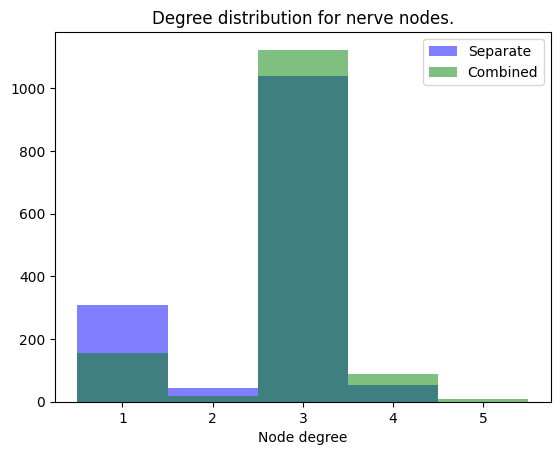

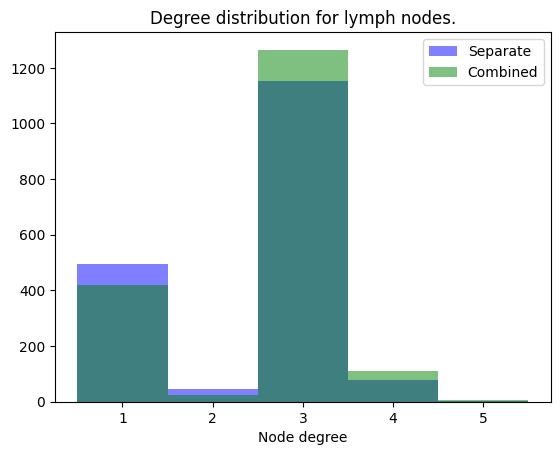

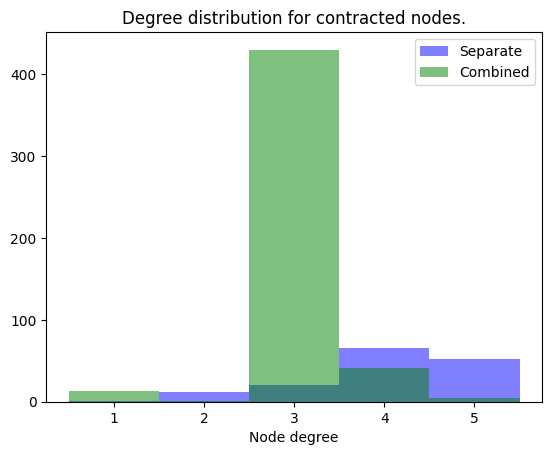

In [7]:
# Look at the average node degree of the different classes 

degree_list_sep = np.array([G_contract_einf_sep.degree[val] for val in G_contract_einf_sep.nodes()])
degree_list_comb = np.array([G_contract_einf_comb.degree[val] for val in G_contract_einf_comb.nodes()])

degrees_classes_sep = {}
degrees_classes_comb = {}

degrees_classes_sep["n"] = degree_list_sep[np.where(np.array(sep_class_labels) == "n")]
degrees_classes_sep["l"] = degree_list_sep[np.where(np.array(sep_class_labels) == "l")]
degrees_classes_sep["c"] = degree_list_sep[np.where(np.array(sep_class_labels) == "c")]

degrees_classes_comb["n"] = degree_list_comb[np.where(np.array(comb_class_labels) == "n")]
degrees_classes_comb["l"] = degree_list_comb[np.where(np.array(comb_class_labels) == "l")]
degrees_classes_comb["c"] = degree_list_comb[np.where(np.array(comb_class_labels) == "c")]

fig, ax = plt.subplots()
ax.set_title("Degree distribution for nerve nodes.")
ax.hist(degrees_classes_sep["n"], bins = np.arange(1,7)-0.5, alpha = 0.5, color = "blue" )
ax.hist(degrees_classes_comb["n"], bins = np.arange(1,7)-0.5, alpha = 0.5, color = "green" )
ax.set_xlabel("Node degree")
ax.legend(("Separate", "Combined"))

fig, ax = plt.subplots()
ax.set_title("Degree distribution for lymph nodes.")
ax.hist(degrees_classes_sep["l"], bins = np.arange(1,7)-0.5, alpha = 0.5, color = "blue" )
ax.hist(degrees_classes_comb["l"], bins = np.arange(1,7)-0.5, alpha = 0.5, color = "green" )
ax.set_xlabel("Node degree")
ax.legend(("Separate", "Combined"))

fig, ax = plt.subplots()
ax.set_title("Degree distribution for contracted nodes.")
ax.hist(degrees_classes_sep["c"], bins = np.arange(1,7)-0.5, alpha = 0.5, color = "blue" )
ax.hist(degrees_classes_comb["c"], bins = np.arange(1,7)-0.5, alpha = 0.5, color = "green")
ax.set_xlabel("Node degree")
ax.legend(("Separate", "Combined"))

In [19]:
# Analyse the number of edge types

node_lab = {}
node_lab_explain = {}
node_class_comb = {}

class_label = -1
class_label_list_sep = []
for k in G_contract_einf_sep.edges():
    hashval = hash(k[0][-1]) + hash(k[1][-1])
    try:
        class_label_list_sep.append(node_lab[hashval])
    except KeyError:
        class_label = class_label +1
        node_class_comb[class_label] = (k[0][-1], k[1][-1])
        node_lab[hashval] = class_label
        node_lab_explain[hashval] = (k[0][-1], k[1][-1])
        class_label_list_sep.append(node_lab[hashval])


print("#############")
print("Distribution of the node labels in the separate dual graph: ")
print(np.unique(class_label_list_sep, return_counts= True))


class_label_list_comb = []
for k in G_contract_einf_comb_relab.edges():
    hashval = hash(k[0][-1]) + hash(k[1][-1])
    try:
        class_label_list_comb.append(node_lab[hashval])
    except KeyError:
        class_label = class_label +1
        node_class_comb[class_label] = (k[0][-1], k[1][-1])
        node_lab[hashval] = class_label
        node_lab_explain[hashval] = (k[0][-1], k[1][-1])
        class_label_list_comb.append(node_lab[hashval])

print("#############")
print("Distribution of the node labels in the combined dual graph: ")
print(np.unique(class_label_list_comb, return_counts= True))

    

class_label_list_sep2 = []
for k in G_link_einf_sep.edges():
    hashval = hash(k[0][-1]) + hash(k[1][-1])
    try:
        class_label_list_sep2.append(node_lab[hashval])
    except KeyError:
        class_label = class_label +1
        node_class_comb[class_label] = (k[0][-1], k[1][-1])
        node_lab[hashval] = class_label
        node_lab_explain[hashval] = (k[0][-1], k[1][-1])
        class_label_list_sep2.append(node_lab[hashval])


print("#############")
print("Distribution of the node labels in the combined dual graph: ")
print(np.unique(class_label_list_sep2, return_counts= True))


#############
Distribution of the node labels in the separate dual graph: 
(array([0, 1, 2, 3, 4]), array([1871,  628, 1561,  602,  144]))
#############
Distribution of the node labels in the combined dual graph: 
(array([0, 1, 2, 3, 4, 5]), array([1698,  432, 1315,  425,  316,  914]))
#############
Distribution of the node labels in the combined dual graph: 
(array([0, 2, 5]), array([2684, 2379,  530]))


Text(0, 0.5, 'Node Count')

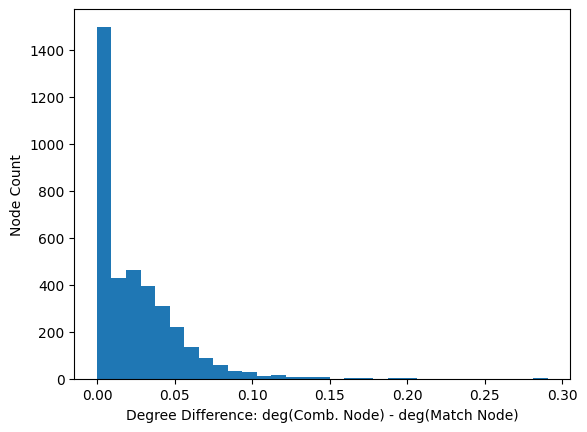

In [10]:
diff, count = np.unique(deg_dev, return_counts = True)

fig = plt.figure()
ax1 = fig.subplots(1)
ax1.hist(res[0], bins = "rice") # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
ax1.set_xlabel("Degree Difference: deg(Comb. Node) - deg(Match Node)")
ax1.set_ylabel("Node Count")


Text(0, 0.5, 'Node Count')

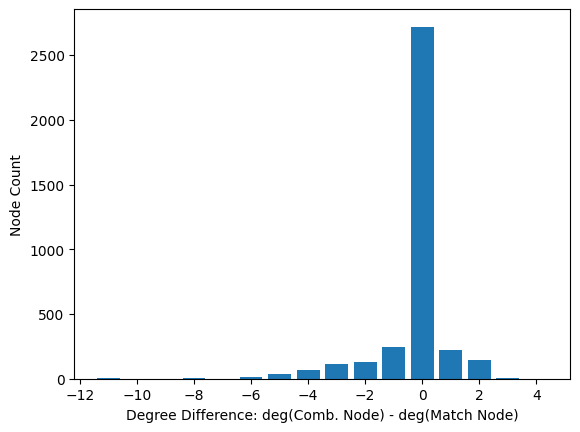

In [11]:
diff, count = np.unique(deg_dev, return_counts = True)

fig = plt.figure()
ax1 = fig.subplots(1)
ax1.bar(diff, count)
ax1.set_xlabel("Degree Difference: deg(Comb. Node) - deg(Match Node)")
ax1.set_ylabel("Node Count")


In [12]:
# converting the graph to a dual graph for classification
import networkx as nx
from torch_geometric.utils.convert import from_networkx
import torch

L = nx.line_graph(G_contract_einf_comb_relab)

feature_dict = {}


for edge in G_contract_einf_comb_relab.edges:
    feature_dict[edge] = G_contract_einf_comb_relab.edges[edge]["x"]

nx.set_node_attributes(L, feature_dict, name="x")



all_nodes = list(L.nodes)
nerve_class = np.array([elem[-1] == "n" for elem in all_nodes])*0
lymph_class = np.array([elem[-1] == "l" for elem in all_nodes])*1
combined_class = np.array([elem[-1] == "c" for elem in all_nodes])*2
class_assign = nerve_class+lymph_class+combined_class


networkDualXG = from_networkx(L)
networkDualXG.y = torch.tensor(class_assign)

# Let's look at the difference in the edge features